<a href="https://colab.research.google.com/github/utquarsh027/imdb_web_scrapping/blob/main/imdb_web_scrapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from requests import get
from bs4 import BeautifulSoup
from warnings import warn
from time import sleep
from random import randint
import numpy as np, pandas as pd
import seaborn as sns

In [2]:
# Note this takes about 40 min to run if np.arange is set to 9951 as the stopping point.

pages = np.arange(1, 1250, 50) # Last time I tried, I could only go to 10000 items because after that the URI has no discernable pattern to combat webcrawlers; I just did 4 pages for demonstration purposes. You can increase this for your own projects.
headers = {'Accept-Language': 'en-US,en;q=0.8'} # If this is not specified, the default language is Mandarin

#initialize empty lists to store the variables scraped
titles = []
years = []
ratings = []
genres = []
runtimes = []
imdb_ratings = []
imdb_ratings_standardized = []
metascores = []
votes = []

for page in pages:
  
   #get request for sci-fi
   response = get("https://www.imdb.com/search/title?genres=sci-fi&"
                  + "start="
                  + str(page)
                  + "&explore=title_type,genres&ref_=adv_prv", headers=headers)
  
   sleep(randint(8,15))
   
   #throw warning for status codes that are not 200
   if response.status_code != 200:
       warn('Request: {}; Status code: {}'.format(requests, response.status_code))

   #parse the content of current iteration of request
   page_html = BeautifulSoup(response.text, 'html.parser')
      
   movie_containers = page_html.find_all('div', class_ = 'lister-item mode-advanced')
  
   #extract the 50 movies for that page
   for container in movie_containers:

       #conditional for all with metascore
       if container.find('div', class_ = 'ratings-metascore') is not None:

           #title
           title = container.h3.a.text
           titles.append(title)

           if container.h3.find('span', class_= 'lister-item-year text-muted unbold') is not None:
            
             #year released
             year = container.h3.find('span', class_= 'lister-item-year text-muted unbold').text # remove the parentheses around the year and make it an integer
             years.append(year)

           else:
             years.append(None) # each of the additional if clauses are to handle type None data, replacing it with an empty string so the arrays are of the same length at the end of the scraping

           if container.p.find('span', class_ = 'certificate') is not None:
            
             #rating
             rating = container.p.find('span', class_= 'certificate').text
             ratings.append(rating)

           else:
             ratings.append("")

           if container.p.find('span', class_ = 'genre') is not None:
            
             #genre
             genre = container.p.find('span', class_ = 'genre').text.replace("\n", "").rstrip().split(',') # remove the whitespace character, strip, and split to create an array of genres
             genres.append(genre)
          
           else:
             genres.append("")

           if container.p.find('span', class_ = 'runtime') is not None:

             #runtime
             time = int(container.p.find('span', class_ = 'runtime').text.replace(" min", "")) # remove the minute word from the runtime and make it an integer
             runtimes.append(time)

           else:
             runtimes.append(None)

           if float(container.strong.text) is not None:

             #IMDB ratings
             imdb = float(container.strong.text) # non-standardized variable
             imdb_ratings.append(imdb)

           else:
             imdb_ratings.append(None)

           if container.find('span', class_ = 'metascore').text is not None:

             #Metascore
             m_score = int(container.find('span', class_ = 'metascore').text) # make it an integer
             metascores.append(m_score)

           else:
             metascores.append(None)

           if container.find('span', attrs = {'name':'nv'})['data-value'] is not None:

             #Number of votes
             vote = int(container.find('span', attrs = {'name':'nv'})['data-value'])
             votes.append(vote)

           else:
               votes.append(None)
       else:
          votes.append(None)

In [19]:
sci_fi_df=pd.DataFrame({'movie':titles,
                        'year':years,
                        'rating':ratings,
                        'genre':genres,
                        'runtime_min':runtimes,
                        'imdb':imdb_ratings,
                        'metascore':metascores
                        }
                       )
sci_fi_df.loc[:,'year']=sci_fi_df['year'].str[-5:-1]
sci_fi_df['n_imdb']=sci_fi_df['imdb']*10
final_df=sci_fi_df.loc[sci_fi_df['year']!='ovie']
final_df['year'].apply(pd.to_numeric)

0      2022
1      2022
2      2022
3      2022
4      2009
       ... 
731    1996
732    2005
733    1960
734    2012
735    1986
Name: year, Length: 735, dtype: int64

# Exploratory Data Analysis

In [21]:
final_df.head()

,movie,year,rating,genre,runtime_min,imdb,metascore,n_imdb
0,The Munsters,2022,PG,"[Comedy, Family, Fantasy]",109,4.6,57,46.0
1,Vesper,2022,,"[Adventure, Drama, Sci-Fi]",114,6.1,70,61.0
2,Thor: Love and Thunder,2022,PG-13,"[Action, Adventure, Comedy]",118,6.4,57,64.0
3,DC League of Super-Pets,2022,PG,"[Animation, Action, Adventure]",105,7.3,56,73.0
4,Avatar,2009,PG-13,"[Action, Adventure, Fantasy]",162,7.8,83,78.0


In [22]:
final_df.describe()

,runtime_min,imdb,metascore,n_imdb
count,735.000000,735.000000,735.000000,735.000000
mean,110.727891,6.456871,56.549660,64.568707
std,19.575800,1.001962,16.538204,10.019618
min,60.000000,1.900000,9.000000,19.000000
25%,97.000000,5.800000,44.000000,58.000000
50%,108.000000,6.500000,57.000000,65.000000
75%,121.500000,7.100000,68.000000,71.000000
max,242.000000,8.800000,98.000000,88.000000


In [23]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 735 entries, 0 to 735
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   movie        735 non-null    object 
 1   year         735 non-null    object 
 2   rating       735 non-null    object 
 3   genre        735 non-null    object 
 4   runtime_min  735 non-null    int64  
 5   imdb         735 non-null    float64
 6   metascore    735 non-null    int64  
 7   n_imdb       735 non-null    float64
dtypes: float64(2), int64(2), object(4)
memory usage: 51.7+ KB


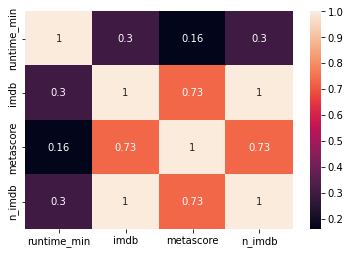

In [30]:
sns.heatmap(final_df.corr(),annot=True);

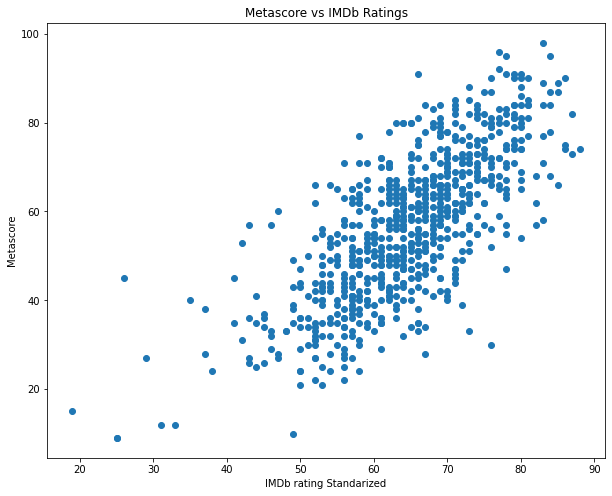

In [38]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.scatter(x=final_df.n_imdb,y=final_df.metascore)
plt.xlabel('IMDb rating Standarized')
plt.ylabel('Metascore')
plt.title('Metascore vs IMDb Ratings')
plt.show();

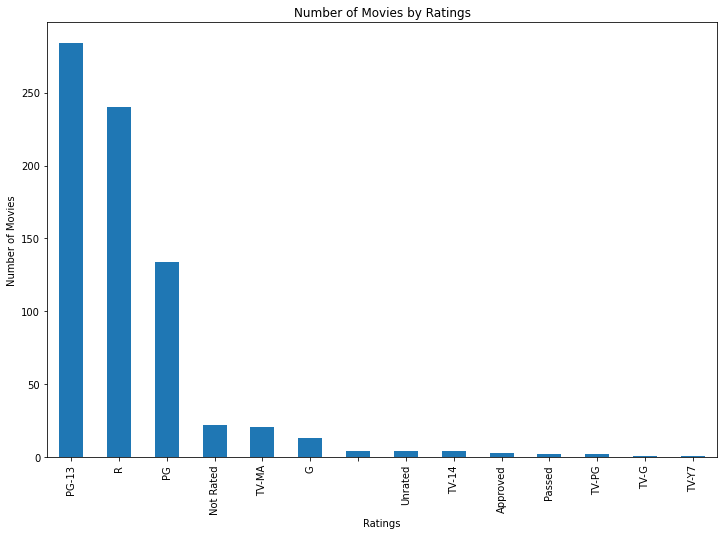

In [44]:
ax=final_df['rating'].value_counts().plot(kind='bar',figsize=(12,8),title='Number of Movies by Ratings')
ax.set_xlabel('Ratings')
ax.set_ylabel('Number of Movies')
ax.plot();

In [47]:
final_df[final_df['rating']=='Approved']

,movie,year,rating,genre,runtime_min,imdb,metascore,n_imdb
520,Invasion of the Body Snatchers,1956,Approved,"[Drama, Horror, Sci-Fi]",80,7.7,92,77.0
597,The Blob,1958,Approved,"[Horror, Sci-Fi]",86,6.3,58,63.0
647,Rollerball,1975,Approved,"[Action, Sci-Fi, Sport]",125,6.6,56,66.0


Text(0, 0.5, 'No. of Movies per year')

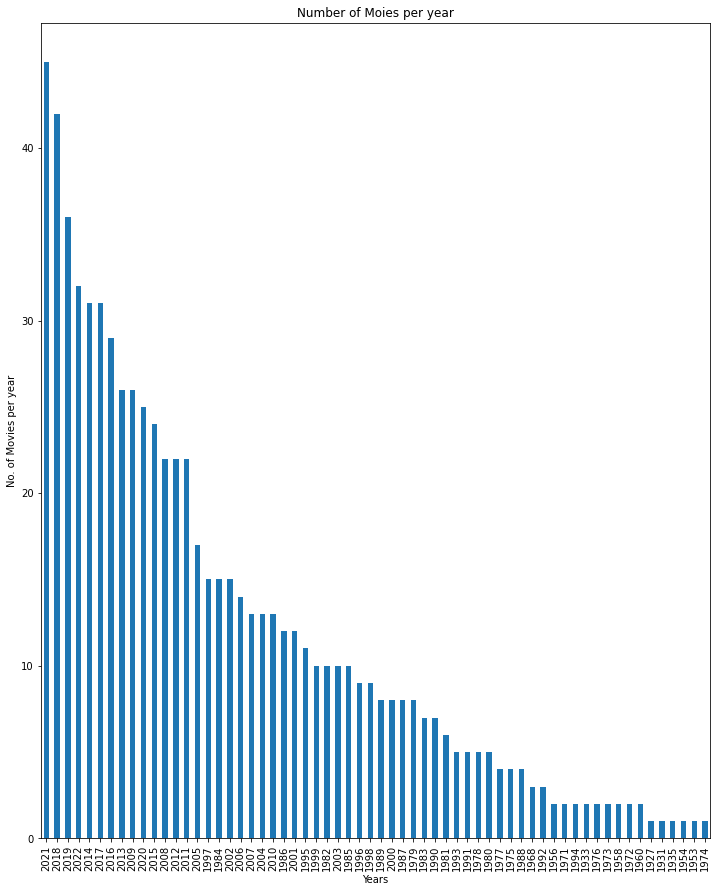

In [53]:
yr=final_df['year'].value_counts().plot(kind='bar',figsize=(12,15),title='Number of Moies per year')
yr.set_xlabel('Years')
yr.set_ylabel('No. of Movies per year')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


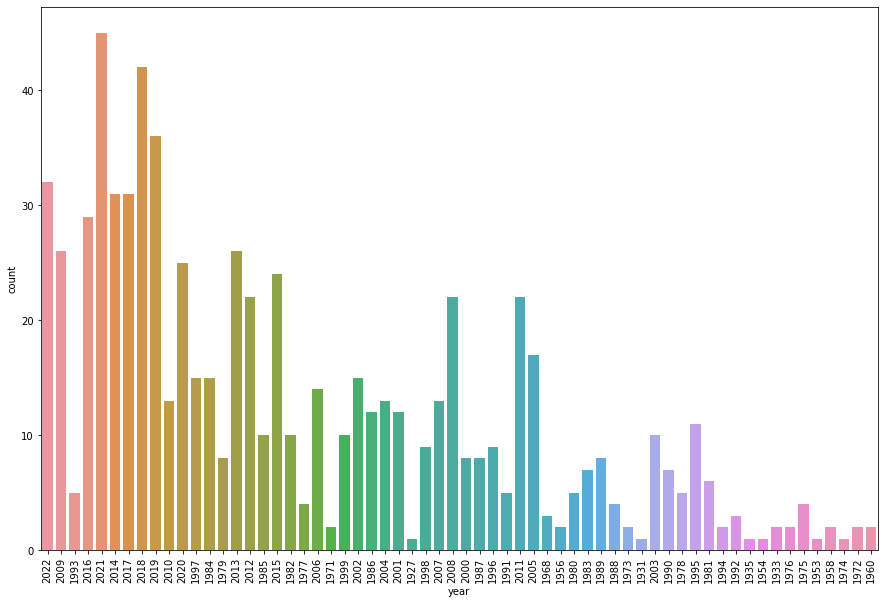

In [66]:

plt.figure(figsize=(15,10))
sns.countplot(final_df['year'])
plt.xticks(rotation=90)
plt.show();